# ALS 를 직접 구현해보자

In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from scipy.sparse import csr_matrix
from numpy.linalg import inv
import matplotlib.pyplot as plt
from sklearn import metrics
DATA_PATH = "drive/MyDrive/"

In [ ]:
# 데이터 불러오기 
# 2019년 10월 E - commerce 로그 데이터 
df = pd.read_parquet(DATA_PATH + "2019-Oct.parquet.gzip", columns = ["event_type", "user_id", "product_id", "category_code"])

# 스마트폰의 조회 로그만 가져온다 
df = df[(df["event_type"] == "view") & (df["category_code"] == "electronics.smartphone")]

# 조회한 상품의 종류가 10개보다 큰 유저의 user_id list를 확보한다 
gb = df.groupby("user_id").nunique()
gb = gb[gb["product_id"] > 10]
upper_user_id_list = user_index = np.array(gb.index)
del gb

# 조회한 상품의 종류가 10개보다 큰 유저중에서 100명울 random sampling 한다.
df = df[df["user_id"].isin(np.random.choice(user_index, 100))]
df = df.reset_index(drop = True)
print(f"총 유저의 수 : {df['user_id'].nunique()} 명")
del upper_user_id_list

# 로그데이터를 유저별로 어떤 상품을 몇번 조회한지 나타내는 데이터로 가공 
df = df.groupby(["user_id", "product_id"]).count()
df = df.reset_index()
df = df.drop(columns = ["category_code"])
df.head()

총 유저의 수 : 100 명


,user_id,product_id,event_type
0,497770459,1002099,1
1,497770459,1002634,1
2,497770459,1003711,1
3,497770459,1004139,1
4,497770459,1004565,1


In [ ]:
# user-item matrix를 생성한다.

user_unique = df['user_id'].unique()
product_unique = df['product_id'].unique()
user_to_idx = {v:k for k,v in enumerate(user_unique)}
product_to_idx = {v:k for k,v in enumerate(product_unique)}
temp_user_data = df['user_id'].map(user_to_idx.get)
df['user_id'] = temp_user_data
temp_product_data = df['product_id'].map(product_to_idx.get)
df['product_id'] = temp_product_data
num_user = df['user_id'].nunique()
num_product = df['product_id'].nunique()

csr_data = csr_matrix((df.event_type, (df.user_id, df.product_id)), shape= (num_user, num_product))
print(f"희소행렬에서 0이 아닌 값의 비중{csr_data.count_nonzero() / (num_user * num_product)}")

희소행렬에서 0이 아닌 값의 비중0.03684601113172542


In [ ]:
# 훈련데이터를 분리한다
# 20%의 data point를 masking 한다
percentage = 0.2

test_set = csr_data.copy()
test_set[test_set !=0] = 1

training_set = csr_data.copy()
nonzero_inds = training_set.nonzero()
nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))

random.seed(0)
num_samples = int(np.ceil(percentage * len(nonzero_pairs)))
samples = random.sample(nonzero_pairs, num_samples)

user_inds = [index[0] for index in samples]
item_inds = [index[1] for index in samples]

training_set[user_inds, item_inds] = 0
training_set.eliminate_zeros()

In [ ]:
# 클래스로 ALS를 구현한다
class ALS():
    def __init__(self, arg_df, arg_alpha, arg_f, arg_lambda):
        self.Pui = np.array(arg_df.toarray())
        self.m = self.Pui.shape[0]
        self.n = self.Pui.shape[1]
        self.alpha = arg_alpha
        if arg_f >= min(self.m, self.n):
            raise Exception("arg_f must less than min(no of user, no of item)")
        else:
            self.f = arg_f
        self.lambda_ = arg_lambda
        self.Rui = np.array(self.Pui > 0, dtype='int64')
        self.Cui = 1 + self.alpha * self.Rui
        self.X = np.reshape(np.random.normal(0,1,self.m*self.f),(self.m,self.f))
        self.Y = np.reshape(np.random.normal(0,1,self.n*self.f),(self.n,self.f))
    def update_X(self, arg_i):
        self.i = arg_i
        self.Cu = np.diag(self.Cui[self.i,:])
        self.Pu = self.Pui[self.i,:]
        self.X[self.i,:] = np.matmul(np.matmul(np.matmul(inv(np.matmul(np.matmul(self.Y.T, self.Cu), self.Y) + self.lambda_ * np.identity(n=self.f, dtype=np.int8)), self.Y.T), self.Cu), self.Pu) 
    def update_Y(self, arg_i):
        self.i = arg_i
        self.Ci = np.diag(self.Cui[:,self.i])
        self.Pi = self.Pui[:,self.i]
        self.Y[self.i,:] = np.matmul(np.matmul(np.matmul(inv(np.matmul(np.matmul(self.X.T, self.Ci), self.X) + self.lambda_ * np.identity(n=self.f, dtype=np.int8)), self.X.T), self.Ci), self.Pi)    
    def fit(self, arg_epoch, arg_num_cores):
        if arg_num_cores > mp.cpu_count():
            raise Exception(f"arg_num_cores must less than {mp.cpu_count()}")
        else:
            self.num_cores = arg_num_cores
        self.error = []    
        mse = np.sum(np.square(self.Pui - np.matmul(self.X, self.Y.T))) / (self.m*self.n)
        self.error.append(mse)
        for iteration in range(arg_epoch):   
            mse = np.sum(np.square(self.Pui - np.matmul(self.X, self.Y.T))) / (self.m*self.n)
            print("="*10 + f"{iteration} update" + "="*10)
            print(f"MSE = {mse}")          
            for i in range(self.m):
                self.update_X(i)
            for i in range(self.n):
                self.update_Y(i)
            self.error.append(mse)
        plt.plot(self.error[1:]) 

==========0 update==========
MSE = 19.80941562796681
==========1 update==========
MSE = 0.3427164172675107
==========2 update==========
MSE = 0.2692225100991757
==========3 update==========
MSE = 0.2506803921906645
==========4 update==========
MSE = 0.24419468797379168
==========5 update==========
MSE = 0.2412970421141263
==========6 update==========
MSE = 0.23980234366123204
==========7 update==========
MSE = 0.2389444726185187
==========8 update==========
MSE = 0.23841625703183486
==========9 update==========
MSE = 0.23807371179103898


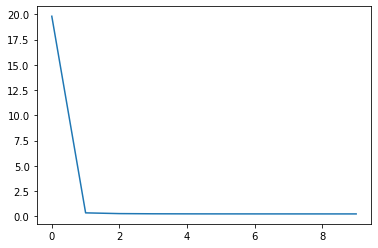

In [ ]:
model = ALS(training_set, 40, 20, 20)
model.fit(10,2)

In [ ]:
pred_mat = np.matmul(model.X, model.Y.T)
pop_items = np.array(training_set.mean(axis = 0)).reshape(-1)
model_auc_list = []
just_auc_list = []
for user in list(set(user_inds)):
    training_row = training_set[user,:].toarray().reshape(-1)
    zero_inds = np.where(training_row == 0)
    pred = pred_mat[user][zero_inds]
    real = test_set.toarray()[user][zero_inds]
    fpr, tpr, thresholds = metrics.roc_curve(real, pred)
    model_auc_list.append(metrics.auc(fpr,tpr))
    pred = pop_items[zero_inds]
    fpr, tpr, thresholds = metrics.roc_curve(real, pred)
    just_auc_list.append(metrics.auc(fpr,tpr))
print(f"ALS 모델의 성능 = {np.mean(model_auc_list)} , 유저 전체의 조회수 평균으로 예측하는 성능 = {np.mean(just_auc_list)}")    

ALS 모델의 성능 = 0.6687680700685313 , 유저 전체의 조회수 평균으로 예측하는 성능 = 0.6872726755524781
